In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

%matplotlib inline

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(260),
        transforms.RandomCrop((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(260),
        transforms.CenterCrop((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Scale(260),
        transforms.CenterCrop((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
#'/home/jim/pytorch/hj_pytorch/hj'
data_dir = '/home/jim/Desktop/tyl/data/hj6'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val','test']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=20,
                                               shuffle=True, num_workers=15)
                for x in ['train', 'val','test']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val','test']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()
print(use_gpu)

True


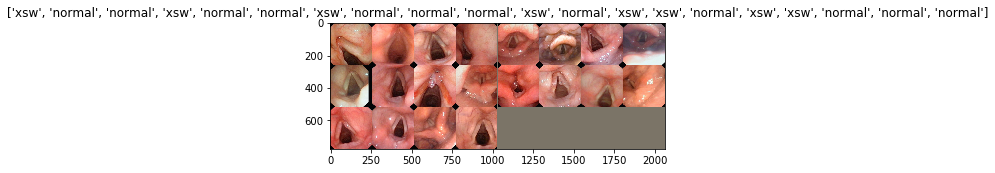

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0
    train_loss=[]
    train_acc=[]
    val_loss=[]
    val_acc=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
                
            if phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model,train_loss,train_acc,val_loss,val_acc

In [5]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=2):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    #lr = init_lr * (0.1**(epoch // lr_decay_epoch))
    lr = init_lr

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {},GT:{}'.format(dset_classes[preds.cpu().numpy()[j]],dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])
            if images_so_far == num_images:
                return 

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              # input height
                out_channels=64,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                #padding=1,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.PReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(64, 64, 3, 1),     
            nn.PReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(64, 128, 3, 1),     
            nn.PReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(128, 256, 3, 1),     
            nn.PReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv5 = nn.Sequential(         
            nn.Conv2d(256, 512, 3, 1),     
            nn.PReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        self.fc1 = nn.Linear(512 * 6 * 6, 2048)   # fully connected layer, output n classes
        self.dp1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(2048, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        return x    # return x for visualization


In [9]:
class Lenet(nn.Module):
    def __init__(self):
        super(Lenet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 6, 3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5, stride=1, padding=0),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Sequential(
            nn.Linear(62*62*16, 120),
            nn.Linear(120, 84),
            nn.Linear(84, 2)
        )


    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [7]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

CNN (
  (conv1): Sequential (
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): PReLU (1)
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential (
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU (1)
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv3): Sequential (
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU (1)
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv4): Sequential (
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU (1)
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv5): Sequential (
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU (1)
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (fc1): Linear (18432 -> 2048)
  (dp1): Dropout (p = 0.5)
  (fc2): Linear (2048 -> 2)
)
Epoch 0/39
----------
LR is set to 0.001
train

/home/jim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


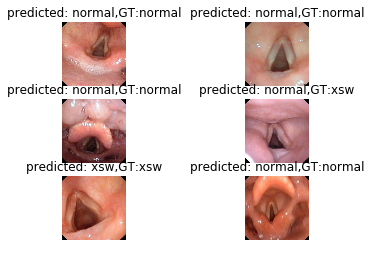

In [9]:
model_ft = CNN()
print(model_ft)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=60)
model_ft,train_loss,train_acc,val_loss,val_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40)
visualize_model(model_ft)
plt.ioff()
plt.show()

In [11]:
torch.save(model_ft.state_dict(), '1011_2.pkl')

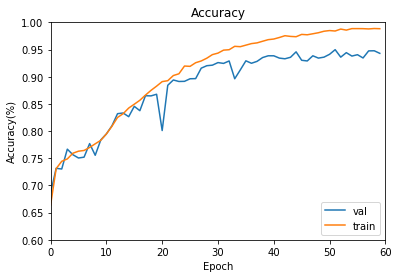

In [32]:
plt.rcParams['font.sans-serif']=['SimHei']

plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlim((0, 60))
plt.ylim((0.6, 1))
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.legend(loc='lower right')
plt.savefig('acc.png',dpi=600)
plt.show() 

In [ ]:
test_y = np.loadtxt('alex_tests_y.txt');
y_pred = np.loadtxt('alex_preds_y.txt');

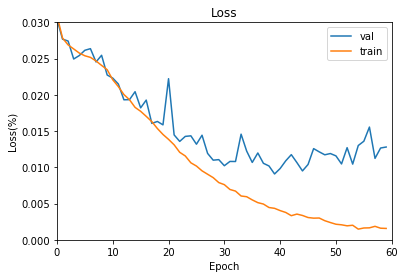

In [33]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.plot(val_loss,label="val")
plt.plot(train_loss,label="train")
plt.xlim((0, 60))
plt.ylim((0, 0.03))
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss(%)')
plt.legend(loc='upper right')
plt.savefig('loss.png',dpi=600)
plt.show() 

In [34]:
from sklearn.metrics import precision_recall_fscore_support as score
plt.rcParams['font.sans-serif']=['SimHei']
model = CNN()
model = model.cuda()
#model.load_state_dict(torch.load('1011_2.pkl'))
tests_y = []
preds_y = []
for data in dset_loaders['test']:
    inputs, labels = data
    if use_gpu:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    test_output = model(inputs)
    test_output = test_output.cpu()
    pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
    pred_y = list(pred_y)
    labels = labels.cpu()
    labels = list(labels.data.numpy())
    tests_y += labels
    preds_y += pred_y

#print(preds_y, 'prediction number')
#print(tests_y, 'real number')

precision, recall, fscore, support = score(tests_y, preds_y)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [ 0.52  0.45]
recall: [ 0.72  0.25]
fscore: [ 0.61  0.32]
support: [5000 4452]


Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[1529  471]
 [ 420 1580]]
Normalized confusion matrix
[[ 0.76  0.24]
 [ 0.21  0.79]]


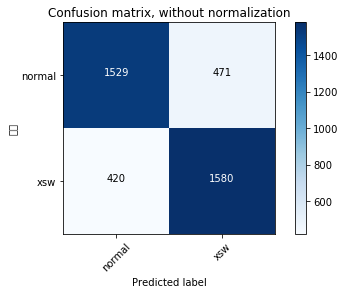

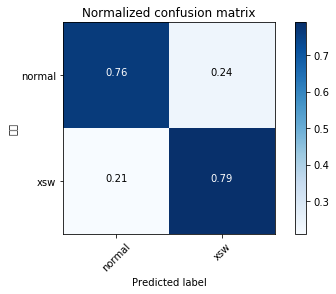

In [17]:
#coding:utf-8
print(__doc__)

import itertools
import numpy as np
from matplotlib.font_manager import *
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif']=['SimHei']
class_names = dset_classes

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    #plt.ylabel('True label')
    plt.ylabel(U'发发')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(tests_y, preds_y)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig('cof_matrix.png')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [35]:
np.savetxt('CNN_train_acc.txt',train_acc);
np.savetxt('CNN_val_acc.txt',val_acc);

In [36]:
np.savetxt('CNN_train_loss.txt',train_loss);
np.savetxt('CNN_val_loss.txt',val_loss);

In [37]:
np.savetxt('CNN_tests_y.txt',tests_y);
np.savetxt('CNN_preds_y.txt',preds_y);